In [1]:
from fastccm import PairwiseCCM, ccm_utils, utils
from fastccm.data import get_truncated_lorenz_rand, get_truncated_rossler_lorenz_rand
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

In [66]:
ccm = PairwiseCCM(device="cpu")

np.random.seed(0)

**CCM for joint Rossler-Lorenz attractor**

In [23]:
X = get_truncated_rossler_lorenz_rand(400,20000,alpha=6, C=2)

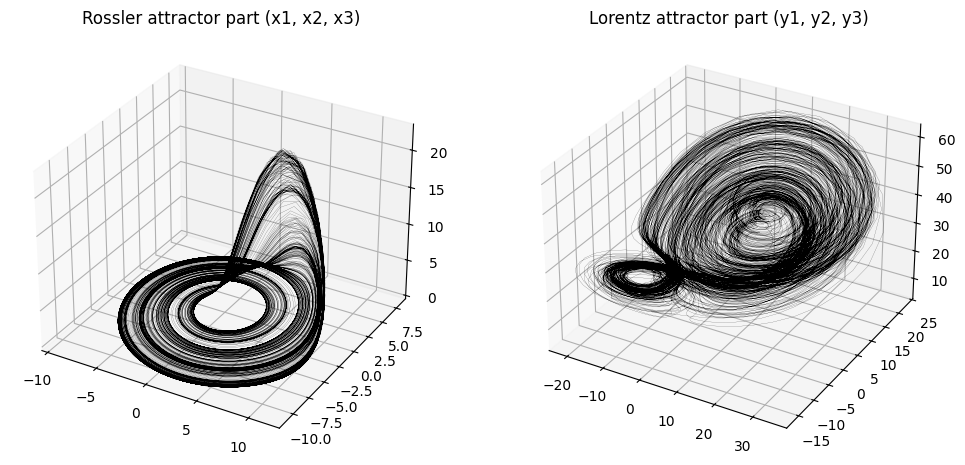

In [24]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(*X[:,[0, 1, 2]].T, lw=0.1,color="black"),
ax1.set_title('Rossler attractor part (x1, x2, x3)')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(*X[:, [4, 3, 5]].T,lw=0.1,color="black")
ax2.set_title('Lorentz attractor part (y1, y2, y3)')

plt.show()

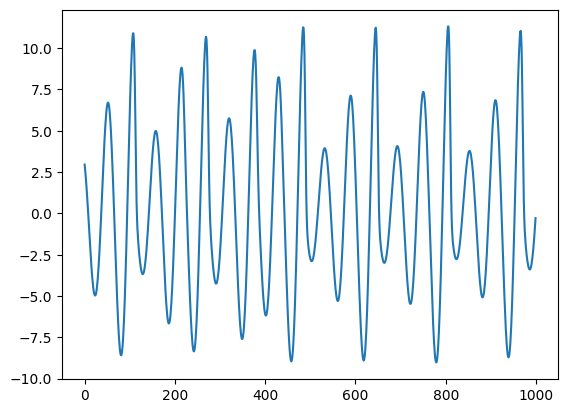

In [25]:
plt.plot(X[:1000,0])

(non-time-delay-embedded) Rossler xmap Lorenz

In [6]:
ccm.score_matrix(X[:,:3][None],X[:,3:][None],library_size=40000,sample_size=40000,exclusion_window=50,tp=0,method="simplex",seed=1).mean()

np.float32(0.70400757)

(non-time-delay-embedded) Lorentz xmap Rossler

In [7]:
ccm.score_matrix(X[:,3:][None],X[:,:3][None],library_size=40000,sample_size=40000,exclusion_window=50,tp=0,method="simplex",seed=1).mean()

np.float32(0.7391915)

Demonstration of convergence and variation of approximation

In [8]:
conv_test_res = ccm_utils.Functions("cpu").convergence_test(X_emb = X[:,:3][None], Y_emb = X[:,3:][None],
                                       library_sizes = [80, 160, 320, 640, 1250, 2500, 5000, 10000, 20000,40000],
                                       sample_size=1000, exclusion_window=20, tp=0, method="simplex",trials=20, seed=1)

<Axes: title={'center': 'Convergence Test Visualization'}, xlabel='Library Size', ylabel='Metric Value'>

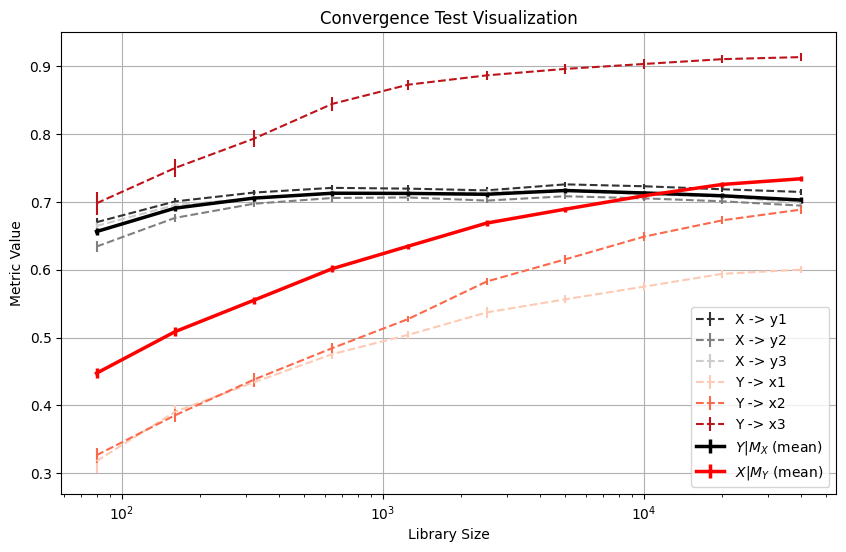

In [9]:
ccm_utils.Visualizer().plot_convergence_test(conv_test_res)

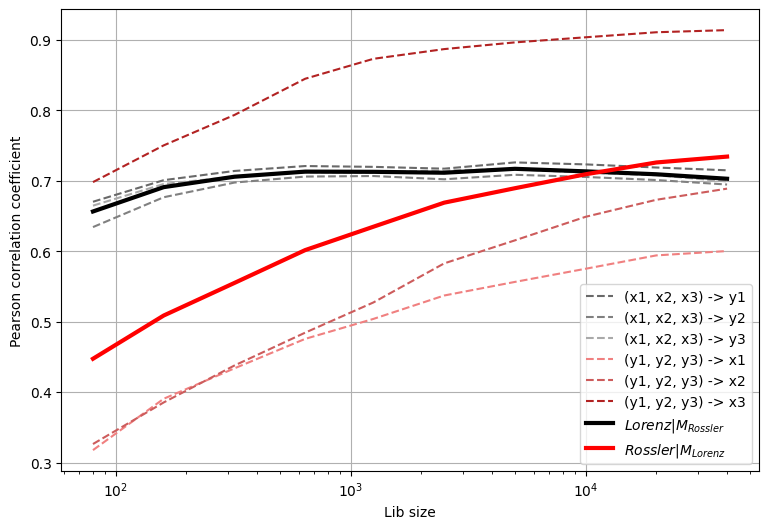

In [10]:
# Plot for (x1, x2, x3) -> y1, y2, y3 using shades of black/gray
plt.figure(figsize=(9,6))
plt.plot(conv_test_res["library_sizes"], conv_test_res["X_to_Y"].mean(axis=1)[:, 0, 0, 0], "--",label="(x1, x2, x3) -> y1", color="dimgray")
plt.plot(conv_test_res["library_sizes"], conv_test_res["X_to_Y"].mean(axis=1)[:, 1, 0, 0], "--",label="(x1, x2, x3) -> y2", color="gray")
plt.plot(conv_test_res["library_sizes"], conv_test_res["X_to_Y"].mean(axis=1)[:, 2, 0, 0], "--",label="(x1, x2, x3) -> y3", color="darkgray")

# Plot for (y1, y2, y3) -> x1, x2, x3 using shades of red
plt.plot(conv_test_res["library_sizes"], conv_test_res["Y_to_X"].mean(axis=1)[:, 0, 0, 0], "--", label="(y1, y2, y3) -> x1", color="lightcoral")
plt.plot(conv_test_res["library_sizes"], conv_test_res["Y_to_X"].mean(axis=1)[:, 1, 0, 0], "--",label="(y1, y2, y3) -> x2", color="indianred")
plt.plot(conv_test_res["library_sizes"], conv_test_res["Y_to_X"].mean(axis=1)[:, 2, 0, 0], "--",label="(y1, y2, y3) -> x3", color="firebrick")

plt.plot(conv_test_res["library_sizes"], conv_test_res["X_to_Y"].mean(axis=1)[:,:,0,0].mean(axis=1),
        label="$Lorenz|M_{Rossler}$",
        lw=3,c="black")

plt.plot(conv_test_res["library_sizes"], conv_test_res["Y_to_X"].mean(axis=1)[:,:,0,0].mean(axis=1),
        label="$Rossler|M_{Lorenz}$",
        lw=3,c="red",
        )
plt.xscale("log")
plt.xlabel("Lib size")
plt.ylabel("Pearson correlation coefficient")
plt.grid()
plt.legend()

Alternative:

In [ ]:
sizes = [80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480]

res_p_XY = []
for i in sizes:
    for e in range(20):
        res_p_XY += [ccm.score_matrix(X[:,:3][None],X[:,3:][None],library_size=100000,sample_size=i,exclusion_window=20,tp=0,method="simplex",nbrs_num = 10,seed=1).mean()]
res_p_XY = np.array(res_p_XY).reshape(-1,20)

res_p_YX= []
for i in sizes:
    for e in range(20):
        res_p_YX += [ccm.score_matrix(X[:,3:][None],X[:,:3][None],library_size=100000,sample_size=i,exclusion_window=20,tp=0,method="simplex",nbrs_num = 10,seed=1).mean()]
res_p_YX = np.array(res_p_YX).reshape(-1,20)

In [ ]:
res_l_XY = []
for i in sizes:
    for e in range(20):
        res_l_XY += [ccm.score_matrix(X[:,:3][None],X[:,3:][None],library_size=i,sample_size=100000,exclusion_window=20,tp=0,method="simplex",nbrs_num = 10,seed=1).mean()]
res_l_XY = np.array(res_l_XY).reshape(-1,20)

res_l_YX = []
for i in sizes:
    for e in range(20):
        res_l_YX += [ccm.score_matrix(X[:,3:][None],X[:,:3][None],library_size=i,sample_size=100000,exclusion_window=20,tp=0,method="simplex",nbrs_num = 10,seed=1).mean()]
res_l_YX = np.array(res_l_YX).reshape(-1,20)

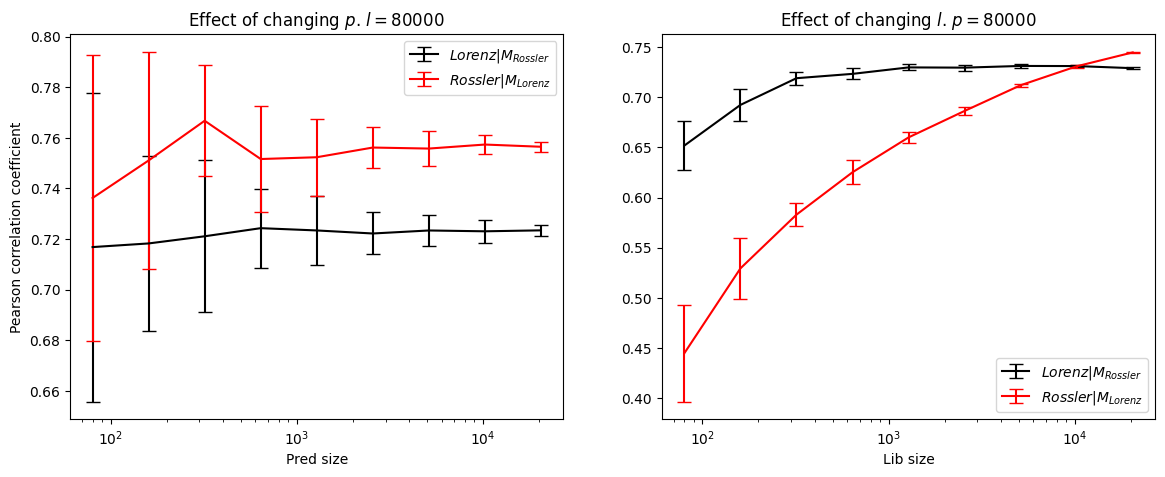

In [15]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Effect of changing $p$. $l = 80000$")
plt.errorbar(sizes,res_p_XY.mean(axis=1),yerr=res_p_XY.std(axis=1),capsize=5, color="black", label="$Lorenz|M_{Rossler}$")
plt.errorbar(sizes,res_p_YX.mean(axis=1),yerr=res_p_YX.std(axis=1),capsize=5, color="red", label="$Rossler|M_{Lorenz}$")
plt.ylabel("Pearson correlation coefficient")
plt.xlabel("Pred size")
plt.legend()
plt.xscale("log")

plt.subplot(1,2,2)
plt.title("Effect of changing $l$. $p = 80000$")
plt.errorbar(sizes,res_l_XY.mean(axis=1),yerr=res_l_XY.std(axis=1),capsize=5, color="black", label="$Lorenz|M_{Rossler}$")
plt.errorbar(sizes,res_l_YX.mean(axis=1),yerr=res_l_YX.std(axis=1),capsize=5, color="red", label="$Rossler|M_{Lorenz}$")
plt.xscale("log")
plt.xlabel("Lib size")
plt.legend()

**Optimal E and Tau**

In [18]:
x = X[:,3]#get_truncated_lorenz_rand(400,n_steps=20000)[:,0]

optimal_E_tau_res = ccm_utils.Functions("cpu").find_optimal_embedding_params(x, x, 2000, 500, exclusion_rad=20,
                                                         E_range=np.arange(2,30),
                                                         tau_range=np.arange(1,30),
                                                         tp_max=50,
                                                         method="simplex",trials=1, metric="corr", seed=1 )

In [20]:
optimal_E_tau_res["optimal_E"], optimal_E_tau_res["optimal_tau"]

(np.int64(7), np.int64(16))

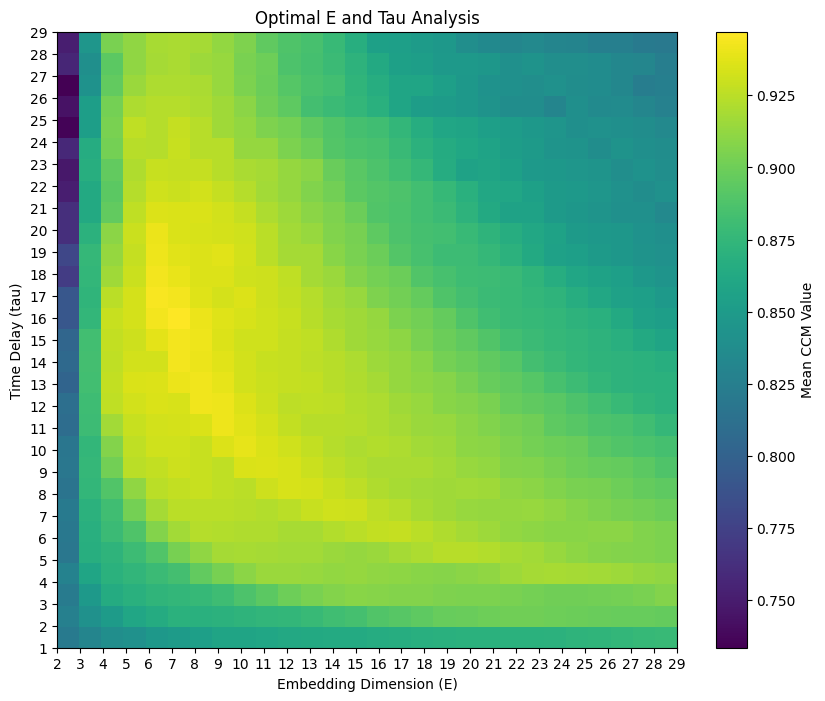

In [19]:


# Example data from the optimal_E_tau_res dictionary
result = optimal_E_tau_res["result"].mean(axis=0)
E_range = optimal_E_tau_res["E_range"]
tau_range = optimal_E_tau_res["tau_range"]

# Create the plot using imshow for more flexibility
plt.figure(figsize=(10, 8))
plt.imshow(result, aspect='auto', extent=[E_range[0], E_range[-1], tau_range[0], tau_range[-1]], origin='lower')

# Set axis labels and title
plt.colorbar(label='Mean CCM Value')
plt.xlabel('Embedding Dimension (E)')
plt.ylabel('Time Delay (tau)')
plt.title('Optimal E and Tau Analysis')

# Set ticks for log scale
plt.xticks(E_range, labels=E_range)
plt.yticks(tau_range, labels=tau_range)

plt.show()


**5 independent Lorentz systems, each coordinate time delay embedded into 5 dimensions. All pairwise CCM.**

In [21]:
N_sys = 5

# Generate X axes of Lorenz systems starting from different initial state
X = np.concatenate([get_truncated_lorenz_rand(280,n_steps=30000).T for i in range(N_sys)])

X_emb = utils.embed(X.T, E=5, tau=30)

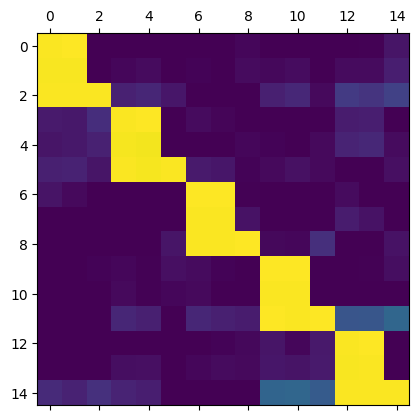

In [24]:
plt.matshow(ccm.score_matrix(X_emb,X_emb,library_size=2000,sample_size=500,exclusion_window=30,tp=100,method="simplex",seed=1)[0],vmax=1,vmin=0)


**Finding a prediction power for a range of Tp**

In [7]:
X = get_truncated_lorenz_rand(4000,n_steps=200000)[None]
Y = X

In [8]:
X.shape, Y.shape

((1, 200000, 3), (1, 200000, 3))

The naive way

6.164546012878418 sec


Text(0, 0.5, 'Rho')

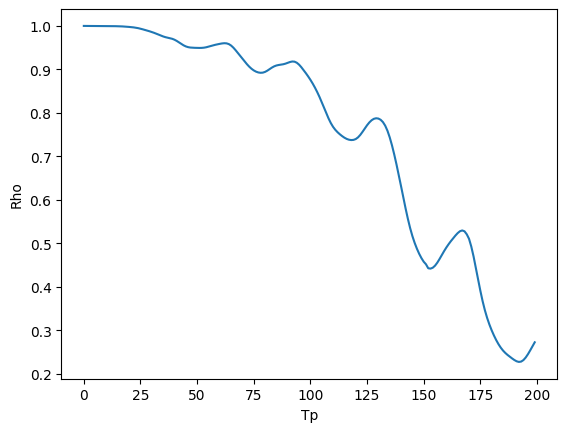

In [9]:
st = time.time()
res = [ccm.score_matrix(X,Y,library_size=5000,sample_size=1000,exclusion_window=50,tp=i,method="simplex",seed=1,nbrs_num = 10)[0,0,0] for i in range(200)]
print(time.time()-st, "sec")
plt.plot(res)
plt.xlabel("Tp")
plt.ylabel("Rho")

The smart way

In [11]:
interval = 200
X_ = X[:,:-(interval-1)]
Y_ = np.transpose(utils.get_td_embedding_np(Y[0],interval,1),axes=(1,0,2))
X_.shape, Y_.shape

((1, 199801, 3), (200, 199801, 3))

0.11318802833557129 sec


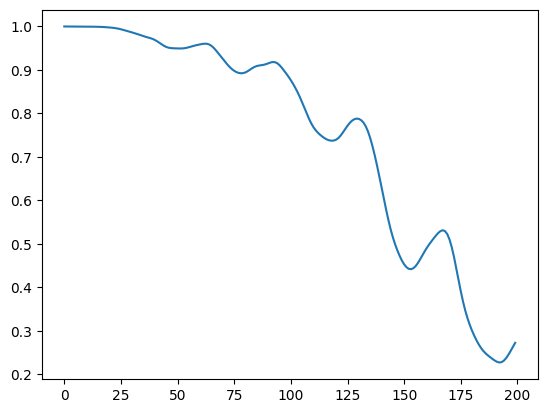

In [12]:
st = time.time()
res = ccm.score_matrix(X_,Y_,library_size=5000,sample_size=1000,exclusion_window=50,tp=0,method="simplex",seed=1,nbrs_num = 10)[0,:,0]
print(time.time()-st, "sec")
plt.plot(res)

Automated:

Text(0, 0.5, 'Pearson correlation coefficient')

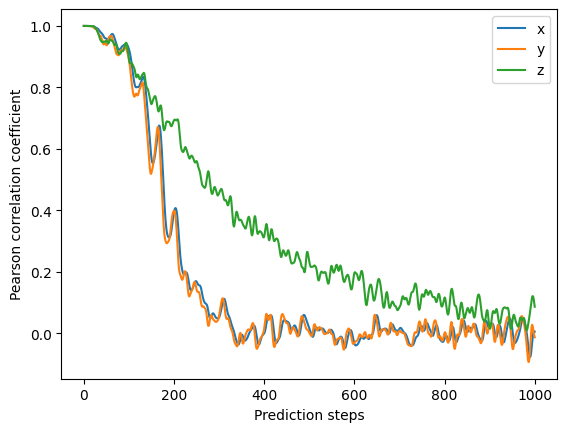

In [13]:
conv_test_res = ccm_utils.Functions("cpu").prediction_interval_test(x_emb = X[0], y_emb = X[0],
                                       library_size=10000,
                                       sample_size=1000, exclusion_window=20, max_tp=1000, method="simplex", seed=1)

plt.plot(conv_test_res["tp_list"],conv_test_res["X_to_Y"][:,:,0].T, label=["x", "y", "z"])
plt.legend()
plt.xlabel("Prediction steps")
plt.ylabel("Pearson correlation coefficient")

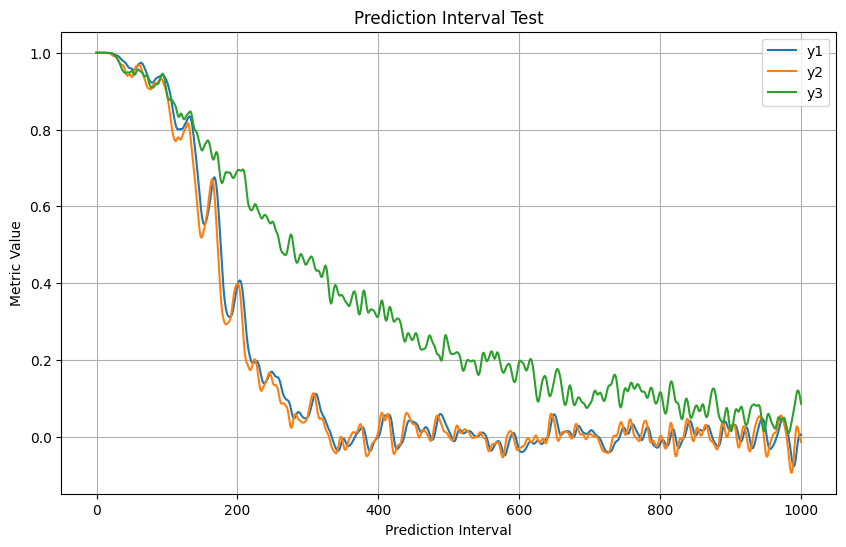

In [14]:
ccm_utils.Visualizer().plot_interval_prediction_test(conv_test_res)

**Prediction horizon with different subset sizes**

In [ ]:
exp_num = 20
tmax = 4000
n_steps = 200000
interval = 250
sample_size = 500
subset_sizes = np.arange(1000,50000,1000)

exp_res = []
for i in range(exp_num):
    X = get_truncated_lorenz_rand(tmax,n_steps=n_steps)[None]
    Y = X[:,:,[0]]

    X_ = X[:,:-(interval-1)]
    Y_ = utils.get_td_embedding_np(Y[0],interval,1)[:,:,0].T[:,:,None]

    res = np.array([ccm.score_matrix(X_,Y_,library_size=i,sample_size=sample_size,exclusion_window=20,tp=0,method="simplex",seed=1,nbrs_num = 10)[0,:,0] for i in subset_sizes])
    exp_res += [res]
exp_res = np.array(exp_res).mean(axis=0)

/var/folders/zm/w82_fr2x7g39mmtpxw51vzdh0000gn/T/ipykernel_11674/1696074535.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet', subset_sizes.shape[0])


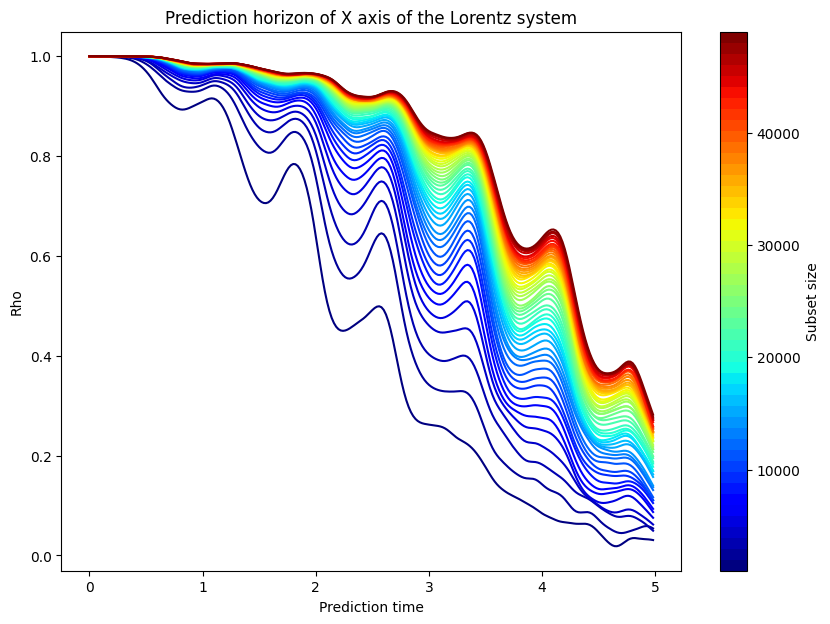

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
cmap = cm.get_cmap('jet', subset_sizes.shape[0])
norm = plt.Normalize(subset_sizes.min(), subset_sizes.max())

for i in range(exp_res.shape[0]):
    ax.plot(tmax/n_steps * np.arange(interval), exp_res[i], color=cmap(i))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Subset size')

ax.set_xlabel("Prediction time")
ax.set_ylabel("Rho")
plt.title("Prediction horizon of X axis of the Lorentz system")
plt.show()

In [ ]:
exp_num = 20
tmax = 4000
n_steps = 200000
interval = 250
sample_size = 500
subset_sizes = np.arange(1000,50000,1000)

exp_res = []
for i in range(exp_num):
    X = get_truncated_lorenz_rand(tmax,n_steps=n_steps)[None]
    Y = X[:,:,[0]]

    X_ = X[:,:-(interval-1)]
    Y_ = utils.get_td_embedding_np(Y[0],interval,1)[:,:,0].T[:,:,None]
    X_ = utils.get_td_embedding_np(X_[0],3,2).reshape(-1,3*3)[None]

    res = np.array([ccm.score_matrix(X_,Y_,library_size=i,sample_size=sample_size,exclusion_window=20,tp=0,method="simplex",seed=1,nbrs_num = 10)[0,:,0] for i in subset_sizes])
    exp_res += [res]
exp_res = np.array(exp_res).mean(axis=0)

/var/folders/zm/w82_fr2x7g39mmtpxw51vzdh0000gn/T/ipykernel_11674/3646813403.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet', subset_sizes.shape[0])


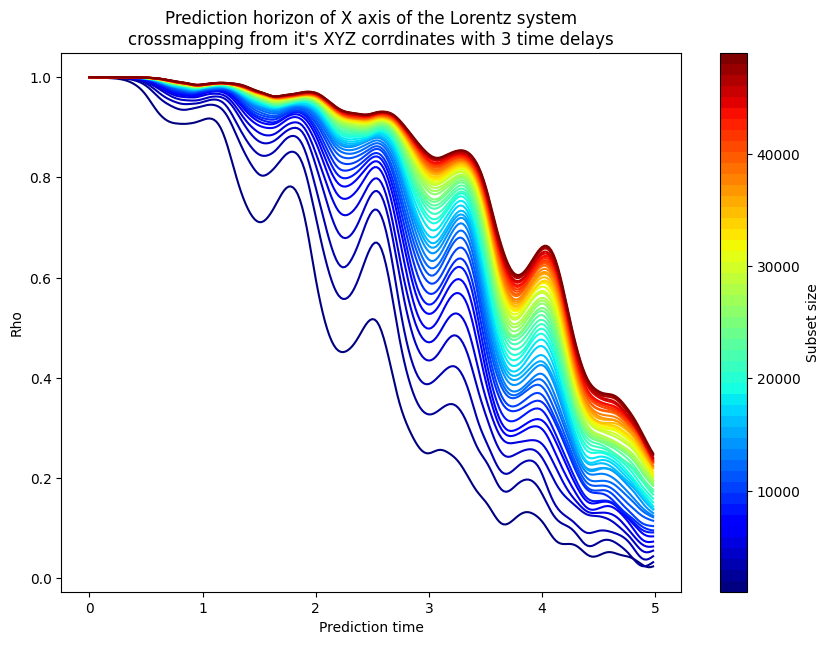

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))
cmap = cm.get_cmap('jet', subset_sizes.shape[0])
norm = plt.Normalize(subset_sizes.min(), subset_sizes.max())

for i in range(exp_res.shape[0]):
    ax.plot(tmax/n_steps * np.arange(interval), exp_res[i], color=cmap(i))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Subset size')

ax.set_xlabel("Prediction time")
ax.set_ylabel("Rho")
plt.title("Prediction horizon of X axis of the Lorentz system\ncrossmapping from it's XYZ corrdinates with 3 time delays")
plt.show()

**S-map, simplex results consistancy**

In [15]:
res = []
for e in range(100):
    r_alpha = np.random.uniform(1,10)
    r_c = np.random.uniform(1,5)

    X = get_truncated_rossler_lorenz_rand(500,50000,alpha=r_alpha, C=r_c)

    smpl = ccm.score_matrix(X[:,:3][None],X[:,3:][None],5000,500,50,tp=0,method="simplex",seed=1,nbrs_num = 20).mean()
    smap = ccm.score_matrix(X[:,:3][None],X[:,3:][None],5000,500,50,tp=0,method="smap",seed=1,theta = 3).mean()
    res += [[smpl, smap]]
res = np.array(res)

Text(0, 0.5, 'S-map')

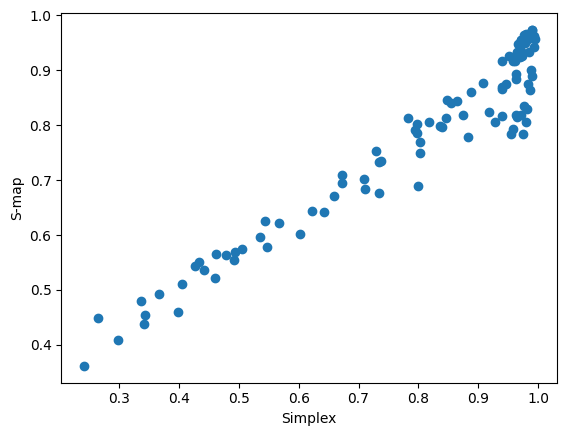

In [18]:
plt.scatter(*res.T)
plt.xlabel("Simplex")
plt.ylabel("S-map")